# Homework 2 - Classification

Name: Dylan Zucker, Dempsey Wade

Class: CSCI 349 - Intro to Data Mining

Semester: 2019SP

Instructor: Brian King

### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from mlxtend.preprocessing import standardize
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import plot_model
from keras import optimizers
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

Using TensorFlow backend.


### Read and Explore Data

In [2]:
df_red = pd.read_csv("../data/winequality-red.csv", sep=";")
df_red.columns = ['fixed_acid','vol_acid','citric_acid','res_sugar','chlorides','free_SO2','total_SO2','density','pH','sulphates','alcohol','quality']
df_red.insert(0, 'wine', 0)
df_white = pd.read_csv("../data/winequality-white.csv", sep=";")
df_white.columns = ['fixed_acid','vol_acid','citric_acid','res_sugar','chlorides','free_SO2','total_SO2','density','pH','sulphates','alcohol','quality']
df_white.insert(0, 'wine', 1)
df_all = df_red.append(df_white)


In [3]:
target_type = pd.api.types.CategoricalDtype(categories = [0, 1], ordered=True)
df_all.wine = df_all.wine.astype(target_type)
df_white.quality = df_white.quality.astype('category')


In [4]:
df_all.shape

(6497, 13)

In [5]:
df_all.info()
df_all.quality.value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
wine           6497 non-null category
fixed_acid     6497 non-null float64
vol_acid       6497 non-null float64
citric_acid    6497 non-null float64
res_sugar      6497 non-null float64
chlorides      6497 non-null float64
free_SO2       6497 non-null float64
total_SO2      6497 non-null float64
density        6497 non-null float64
pH             6497 non-null float64
sulphates      6497 non-null float64
alcohol        6497 non-null float64
quality        6497 non-null int64
dtypes: category(1), float64(11), int64(1)
memory usage: 666.3 KB


6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

In [6]:
df_all.head()

,wine,fixed_acid,vol_acid,citric_acid,res_sugar,chlorides,free_SO2,total_SO2,density,pH,sulphates,alcohol,quality
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,0,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,0,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,0,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [7]:
mins = df_all.groupby("wine").apply(min).drop(["wine","quality"], axis = 1)
mins.columns = ["min_" + x for x in mins.columns]
maxs = df_all.groupby("wine").apply(max).drop(["wine","quality"], axis = 1)
maxs.columns = ["max_" + x for x in maxs.columns]
pd.concat([mins, maxs], axis = 1).transpose()

#mins = df_all.groupby("wine").apply(min).drop(["wine","quality"], axis = 1)
#maxs = df_all.groupby("wine").apply(max).drop(["wine","quality"], axis = 1)
#mins_maxs = pd.concat([mins, maxs]).transpose()
#mins_maxs.columns = ["red min", "white min"]


wine,0,1
min_fixed_acid,4.60000,3.80000
min_vol_acid,0.12000,0.08000
min_citric_acid,0.00000,0.00000
min_res_sugar,0.90000,0.60000
min_chlorides,0.01200,0.00900
min_free_SO2,1.00000,2.00000
min_total_SO2,6.00000,9.00000
min_density,0.99007,0.98711
min_pH,2.74000,2.72000
min_sulphates,0.33000,0.22000


/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


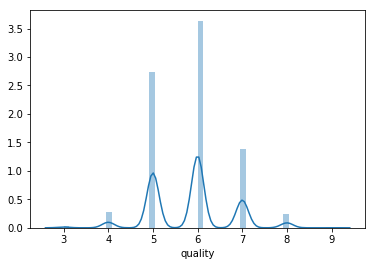

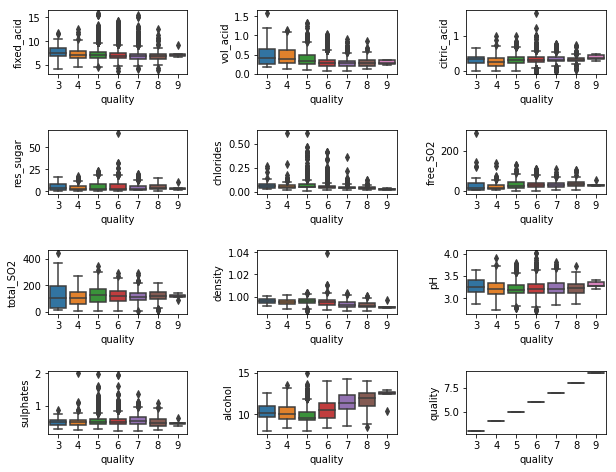

In [8]:
sns.distplot(df_all["quality"])
plt.title = "target"
plt.show()

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.9, wspace=0.5)
for i in range(1, len(df_all.columns)):
    fig.add_subplot(5, 3, i)
    #sns.distplot(df_wine[df_wine.columns[i]]).set_title(df_wine.columns[i])
    sns.boxplot(x="quality", y=df_all.columns[i], data=df_all)
plt.show()
    

## Models

### Set Up Datasets For Training

In [9]:
X = df_all.drop("quality", axis = 1)
y = df_all[["quality"]]
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)
X, y = shuffle(X, y, random_state = 0)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X, y, test_size = 0.7, random_state = 0)
y_train_bin = pd.get_dummies(y_train_full["quality"])
y_test_bin = pd.get_dummies(y_test_full["quality"])
y_train_real = y_train_full.apply(pd.to_numeric)
y_test_real = y_test_full.apply(pd.to_numeric)

### Linear Regression

In [10]:
kfold = KFold(5, random_state = 100, shuffle = True)
df_results = pd.DataFrame([],columns=["y_test", "pred"])
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    clf_reg = LinearRegression()
    clf_reg.fit(X_train, y_train)
    y_pred = clf_reg.predict(X_test)
    row = pd.DataFrame({"y_test": y_test["quality"].values.astype("float"), "pred": y_pred.ravel().astype("float")})
    df_results = df_results.append(row)

    
#print("Accuracy score: ", accuracy_score(df_results["y_test"].values, df_results["pred"].values))
cm= pd.DataFrame(confusion_matrix(df_results["y_test"].values.astype("int"), df_results["pred"].values.astype("int")))

In [11]:

fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.values.sum() - (fp + fn + tp)
print("Accuracy: ", (tp + tn)/(tn+fp+fn+tp))

Accuracy:  0    0.995229
1    0.942281
2    0.610590
3    0.552871
4    0.833000
5    0.970294
6    0.999230
dtype: float64


### Random Forest Classifier

In [12]:
param_grid = {'criterion' : ['gini', 'entropy'], "n_estimators":[100, 110], "max_depth": [17, 18], "min_samples_split":[2,3,4],"min_samples_leaf":[1,2], "random_state":[0] }
grid_rf = GridSearchCV(RandomForestClassifier(),  param_grid, return_train_score=True,scoring=["accuracy"],refit="accuracy", cv=5) 
grid_result_rf = grid_rf.fit(X_train_full,y_train_full["quality"])
print(grid_result_rf)

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'n_estimators': [100, 110], 'max_depth': [17, 18], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2], 'random_state': [0]},
       pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
       scoring=['accuracy'], verbose=0)


In [13]:
print(grid_rf.best_score_)
print(grid_rf.best_params_)

0.5910723447922012
{'criterion': 'gini', 'max_depth': 18, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 0}


In [14]:
kfold = KFold(5, random_state = 100, shuffle = True)
df_results = pd.DataFrame([],columns=["y_test", "pred"])
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    clf_rf = RandomForestClassifier(criterion="gini", max_depth=18, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state=0)
    clf_rf.fit(X_train, y_train["quality"])
    y_pred_rf = clf_rf.predict(X_test)
    row = pd.DataFrame({"y_test": y_test["quality"].values.astype("float"), "pred": y_pred_rf})
    df_results = df_results.append(row)

cm= pd.DataFrame(confusion_matrix(df_results["y_test"].values.astype("int"), df_results["pred"].values.astype("int")))

In [15]:

fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.values.sum() - (fp + fn + tp)
print("Accuracy: ", (tp + tn)/(tn+fp+fn+tp))

Accuracy:  0    0.995229
1    0.969063
2    0.821918
3    0.726489
4    0.886563
5    0.980299
6    0.999230
dtype: float64


### SVM Regression Model

In [ ]:
param_grid = {"gamma":["scale"], "C":[1,2,3], "degree":[3,4,5], "epsilon":[.2,.3,.4] }
grid_svm = GridSearchCV(SVR(),  param_grid, return_train_score=True, cv=5) 
grid_result_svm = grid_svm.fit(X_train, y_train["quality"])
print(grid_result_svm)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': ['scale'], 'C': [1, 2, 3], 'degree': [3, 4, 5], 'epsilon': [0.2, 0.3, 0.4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)


In [ ]:
print(grid_svm.best_score_)
print(grid_svm.best_params_)

0.1797239927595725
{'C': 3, 'degree': 3, 'epsilon': 0.3, 'gamma': 'scale'}


In [ ]:
kfold = KFold(5, random_state = 100, shuffle = True)
df_results = pd.DataFrame([],columns=["y_test", "pred"])
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    clf_svm = SVR(gamma='scale', C=3.0, epsilon=0.4, degree = 3)
    clf_svm.fit(X_train, y_train["quality"]) 
    y_pred_svm = clf_svm.predict(X_test)
    row = pd.DataFrame({"y_test": y_test["quality"].values.astype("float"), "pred": y_pred_svm})
    df_results = df_results.append(row)
#print(accuracy_score(y_test_real["quality"].values.astype("float"), y_pred_svm.round()))
print(accuracy_score(df_results["y_test"].values.astype("int"), df_results["pred"].values.astype("int")))

0.44543635524088043


### Keras Model

In [ ]:
def create_keras_model(num_hidden = 2, hidden_size = 10, activation="relu", opt = "adam", num_inputs = 12, num_outputs = 7):
    model = Sequential()
    model.add(Dense(hidden_size, input_dim = num_inputs,activation = "relu"))
    for i in range(num_hidden - 1):
        model.add(Dense(hidden_size, activation = activation))
    
    model.add(Dense(num_outputs, activation = "softmax"))
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
model=KerasClassifier(build_fn=create_keras_model, verbose=0)
param_grid = { 'opt' : ['adam', 'sgd'], "hidden_size":[10,12], "activation":["relu"], "epochs":[5,10], "batch_size":[4,8] }
grid_nn = GridSearchCV(model,  param_grid, return_train_score=True, cv=5) 
grid_result_nn = grid_nn.fit(X_train_full,y_train_bin)

In [36]:
print("Best Score: ", grid_result_nn.best_score_)
print("Best params: ", grid_result_nn.best_params_)

Best Score:  0.4371472550025654
Best params:  {'activation': 'relu', 'batch_size': 4, 'epochs': 5, 'hidden_size': 10, 'opt': 'adam'}


In [37]:
kfold = KFold(5, random_state = 100, shuffle = True)
df_results = pd.DataFrame([],columns=["y_test", "pred"])
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
   
    y_train = pd.get_dummies(y_train["quality"])
    y_test = pd.get_dummies(y_test["quality"])
    clf = KerasClassifier(build_fn=create_keras_model, activation="relu", hidden_size=12, opt="adam",  verbose=0, epochs=10, batch_size=8)
    clf.fit(X_train, y_train)
    y_pred_nn = clf.predict(X_test)
    y_test_unbin_nn = np.array(y_test.apply(lambda x: np.array(x).argmax(), axis = 1))
    row = pd.DataFrame({"y_test": y_test_unbin_nn, "pred": y_pred_nn})
    df_results = df_results.append(row)
cm =  pd.DataFrame(confusion_matrix(df_results["y_test"].values.astype("int"), df_results["pred"].values.astype("int")))#confusion_matrix(y_test_unbin_nn,np.array( y_pred_nn).astype("int"))

print(cm)



   0  1    2     3   4  5  6
0  1  0   14    15   0  0  0
1  0  0   97   118   1  0  0
2  0  0  775  1348  15  0  0
3  0  0  463  2286  87  0  0
4  0  0   73   914  91  1  0
5  0  0    9   162  22  0  0
6  0  0    0     5   0  0  0


In [39]:
cm = pd.DataFrame(cm)
fp = cm.sum(axis=0) - np.diag(cm)  
fn = cm.sum(axis=1) - np.diag(cm)
tp = np.diag(cm)
tn = cm.values.sum() - (fp + fn + tp)
print("Accuracy: ", (tp + tn)/(tn+fp+fn+tp))

Accuracy:  0    0.995536
1    0.966754
2    0.689241
3    0.521010
4    0.828690
5    0.970140
6    0.999230
dtype: float64


### Decision Tree Classifier

In [40]:
param_grid = { 'criterion' : ['gini', 'entropy'], 'max_depth' : [3,4,5,6,7], "min_samples_split":[2,3,4], "min_samples_leaf": [1,2,3] }
grid_dt = GridSearchCV(DecisionTreeClassifier(),  param_grid, scoring=["accuracy","f1_macro"], return_train_score=True, refit="accuracy", cv=5) 
grid_result_dt = grid_dt.fit(X_train_full,y_train_full["quality"].values)
print(grid_result_dt)

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being 

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samp

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5, 6, 7], 'min_samples_split': [2, 3, 4], 'min_samples_leaf': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit='accuracy', return_train_score=True,
       scoring=['accuracy', 'f1_macro'], verbose=0)


In [41]:
print("Best Score: ", grid_result_dt.best_score_)
print("Best params: ", grid_result_dt.best_params_)

Best Score:  0.5187275525910724
Best params:  {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 4}


In [42]:
kfold = KFold(5, random_state = 100, shuffle = True)
df_results = pd.DataFrame([],columns=["y_test", "pred"])
for train_index, test_index in kfold.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]
    clf_dt = DecisionTreeClassifier(criterion= 'gini', max_depth= 7, min_samples_leaf= 2, min_samples_split= 3)
    clf_dt.fit(X_train, y_train["quality"].values)
    y_pred_dt = clf.predict(X_test)
    row = pd.DataFrame({"y_test": y_test["quality"].values, "pred": y_pred_dt})
    df_results = df_results.append(row)
cm_dt =  pd.DataFrame(confusion_matrix(df_results["y_test"].values.astype("int"), df_results["pred"].values.astype("int")))
print(cm_dt)


      0     1  2  3  4  5  6  7
0     0     0  0  0  0  0  0  0
1    16    13  0  1  0  0  0  0
2   141    75  0  0  0  0  0  0
3  1452   686  0  0  0  0  0  0
4  1034  1800  2  0  0  0  0  0
5   182   893  1  3  0  0  0  0
6    24   167  2  0  0  0  0  0
7     1     4  0  0  0  0  0  0


In [43]:
cm_dt = pd.DataFrame(cm_dt)
fp = cm_dt.sum(axis=0) - np.diag(cm_dt)  
fn = cm_dt.sum(axis=1) - np.diag(cm_dt)
tp = np.diag(cm_dt)
tn = cm_dt.values.sum() - (fp + fn + tp)
print("Accuracy: ", (tp + tn)/(tn+fp+fn+tp))

Accuracy:  0    0.561336
1    0.439434
2    0.965984
3    0.670309
4    0.563491
5    0.833923
6    0.970294
7    0.999230
dtype: float64


## ROC Curve

In [46]:
y_scores = clf_rf.predict_proba(X_test_full)
fpr = {}
tpr = {}
roc_auc = {}
for i in range(y_test_bin.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(np.array(y_test_bin)[:, i], y_scores[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


/Users/Dylan/anaconda3/envs/csci349_2019sp/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


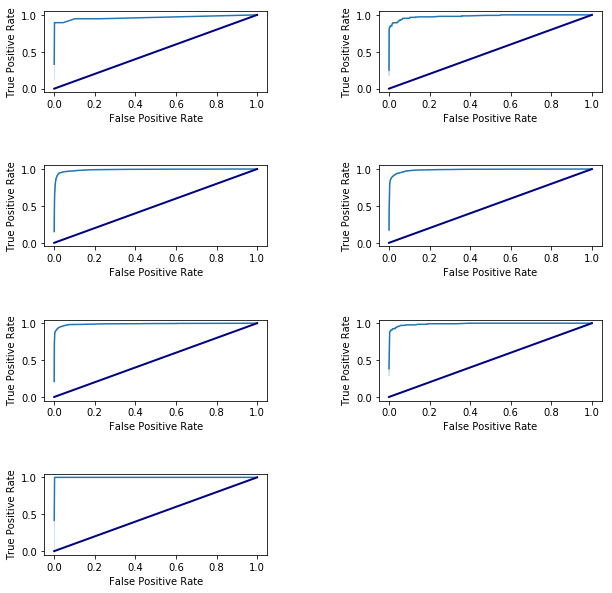

In [47]:
fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(hspace=0.9, wspace=0.5)
for i in range(1, y_test_bin.shape[1]+1):
    fig.add_subplot(4, 2, i)
    lw = 2
    sns.lineplot(fpr[i-1], tpr[i-1])
    sns.lineplot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plt.show()

In [53]:
auc = pd.Series(roc_auc)
auc.index = [3, 4, 5, 6, 7, 8, 9]
print(auc)

3    0.964074
4    0.983344
5    0.990274
6    0.989480
7    0.990445
8    0.991972
9    1.000000
dtype: float64
